In [1]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

sns.set()

In [10]:
# import the necessary packages
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

##
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model, Sequential

In [3]:
from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2113536/2110848 [==============================] - 0s 0us/step


C:\Users\mhasa\PycharmProjects\venvs\dl_venv\lib\site-packages\tensorflow_core\python\keras\datasets\reuters.py:113: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
C:\Users\mhasa\PycharmProjects\venvs\dl_venv\lib\site-packages\tensorflow_core\python\keras\datasets\reuters.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [4]:
word_index = reuters.get_word_index()  # dict of word to index
id_to_word = {val: key for key, val in word_index.items()}


def construct_review(word_indices: list):
    words = []
    for index in word_indices:
        words.append(id_to_word.get(index - 3, "?"))
    review = " ".join(words)
    return review

557056/550378 [==============================] - 0s 0us/step


In [5]:
construct_review(train_data[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [6]:
# one hot encode the data so all reviews are the same length
def vectorize_sequences(sequences, dimension=10_000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [7]:
# vectorize the data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [8]:
# binarize the labels
lb = LabelBinarizer()
train_labels_transformed = lb.fit_transform(train_labels)

In [9]:
test_labels_transformed = lb.transform(test_labels)

In [11]:
model = Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(46, activation="softmax")
])

In [12]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = train_labels_transformed[:1000]
partial_y_train = train_labels_transformed[1000:]

In [14]:
n_epochs = 20
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=n_epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 399us/sample - loss: 2.5487 - accuracy: 0.5261 - val_loss: 1.6936 - val_accuracy: 0.6210
Epoch 2/20
7982/7982 [==============================] - 1s 132us/sample - loss: 1.4062 - accuracy: 0.6962 - val_loss: 1.3077 - val_accuracy: 0.7190
Epoch 3/20
7982/7982 [==============================] - 1s 130us/sample - loss: 1.0581 - accuracy: 0.7705 - val_loss: 1.1448 - val_accuracy: 0.7450
Epoch 4/20
7982/7982 [==============================] - 1s 130us/sample - loss: 0.8314 - accuracy: 0.8240 - val_loss: 1.0697 - val_accuracy: 0.7700
Epoch 5/20
7982/7982 [==============================] - 1s 144us/sample - loss: 0.6684 - accuracy: 0.8622 - val_loss: 1.0079 - val_accuracy: 0.7900
Epoch 6/20
7982/7982 [==============================] - 1s 131us/sample - loss: 0.5425 - accuracy: 0.8861 - val_loss: 0.9745 - val_accuracy: 0.8020
Epoch 7/20
7982/7982 [==============================] - 1s 133us

[INFO] evaluating network...


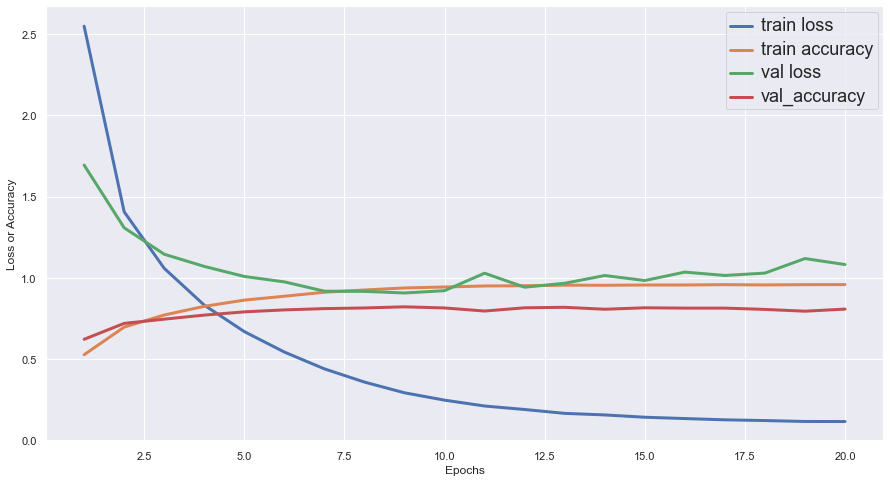

In [15]:
# evaluate the network
print("[INFO] evaluating network...")

# plot the performance
epochs = range(1, n_epochs + 1)
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs, loss, accuracy, val_loss, val_accuracy],
                       columns=['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18');  # for legend text